<a href="https://colab.research.google.com/github/SashkaHacker/BigData/blob/main/%D0%9B%D0%A04_%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи


**Цель работы:** применение идей коллаборативной фильтрации и фильтрации, основанной на контенте, для формирования рекомендаций фильмов пользователям.

**Краткое описание:** в лабораторной работе необходимо выполнить 3 задания на исследование данных о фильмах с сайта [MovieLens](http://movielens.org) и применение двух подходов к построению рекомендаций фильмов – на основе предпочтений похожих пользователей и на основе предпочтений пользователя, для которого генерируется рекомендация.

#  Данные


Набор данных `ml-25m` включает в себя описание 5-звёздного рейтинга фильмов с сайта [MovieLens](http://movielens.org) – одного из старейших сервисов по рекомендации фильмов. Набор данных содержит 25 000 095 оценок и 1 093 360 применений тегов к 62 423 фильмам. Эти данные были созданы 162 541 пользователями в период с 9 января 1995 года по 21 ноября 2019 года – именно в этот день был сгенерирован датасет.

Пользователи были выбраны случайным образом при условии, что пользователь оценил как минимум 20 фильмов. Демографическая информация в набор данных не включена. Каждый пользователь представлен только `id`.

В папке [Data/lab4](https://drive.google.com/drive/folders/1tHu5zzSTF_ZB9OfeaWvM4cWwGM2q99b8?usp=sharing) расположено несколько таблиц с характеристиками фильмов. Также эти данные доступны для скачивания [по ссылке](https://grouplens.org/datasets/movielens/25m/) (как и другие наборы данных от GroupLens). Все задания лабораторной работы необходимо выполнять по этим данным.

Данные включают в себя файлы: `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` и `tags.csv`.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
sns.set_context("notebook")

In [10]:
# загрузка данных из папки Data/lab4
!gdown 1KjMiVB0j5B6yF5vnwLGYcThQaPkPx0tH
!gdown 1uWeLWEkkd_GX8HoMVxpRXdSg7BgfSCdR
!gdown 1xcv1ZY8bwi-AkqZGs5_f8kIPXWHa8Q1W
!gdown 1ahac-9nULw9C1aS7pxh05RTtSlbxJxlS
!gdown 1bYRHTZJ1eZ5T2IugHxsDwrc4xuaWB-A9
!gdown 1XaxxydOXE5zdhhehv-Wig99CuJmg0B_w

Downloading...
From (original): https://drive.google.com/uc?id=1KjMiVB0j5B6yF5vnwLGYcThQaPkPx0tH
From (redirected): https://drive.google.com/uc?id=1KjMiVB0j5B6yF5vnwLGYcThQaPkPx0tH&confirm=t&uuid=d784db49-72c7-40a4-b20f-f53f2b9f1d24
To: /content/genome-scores.csv
100% 435M/435M [00:04<00:00, 92.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uWeLWEkkd_GX8HoMVxpRXdSg7BgfSCdR
To: /content/genome-tags.csv
100% 18.1k/18.1k [00:00<00:00, 25.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xcv1ZY8bwi-AkqZGs5_f8kIPXWHa8Q1W
To: /content/links.csv
100% 1.37M/1.37M [00:00<00:00, 78.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ahac-9nULw9C1aS7pxh05RTtSlbxJxlS
To: /content/movies.csv
100% 3.04M/3.04M [00:00<00:00, 46.3MB/s]
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

### Таблица ```tags.csv```
##### **Описание**
Таблица содержит все теги фильмов. Теги - это сгенерированные пользователями метаданные о фильмах. Каждый тег обычно представляет собой слово или коротку фразу. Значение, ценность и цель каждого тега определяется каждым пользователем.


##### **Формат данных**


```
userId,movieId,tag,timestamp
3,260,classic,1439472355
3,260,sci-fi,1439472256
4,1732,dark,comedy,1573943598
...
```
##### **Описание полей**

 - ``` userId``` — идентификатор пользователя;
 - ``` movieId``` — идентификатор фильма;
 - ``` tag``` — название тега;
 - ``` timestamp``` — количество секунд, прошедших с 1 января 1970.


In [11]:
# создание датафрейма тегов
tag=pd.read_csv('tags.csv')
tag.sample(3)

,userId,movieId,tag,timestamp
78311,6550,5992,sense of life,1528593090
45149,6550,909,spaghetti,1528513076
69605,6550,4485,attitude,1528349992


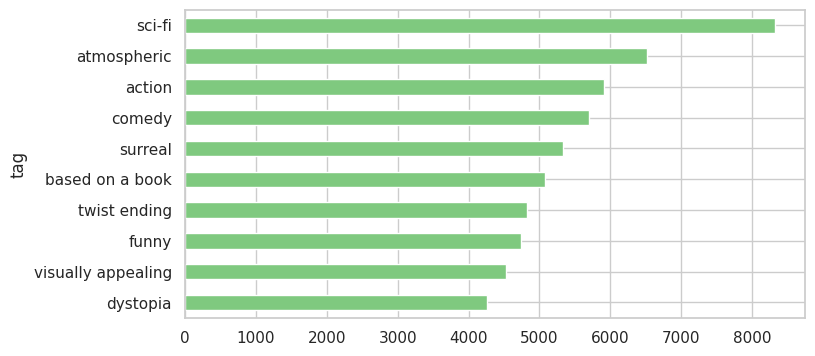

In [12]:
tag_counts = tag['tag'].value_counts()
tag_counts[:10].sort_values().plot(kind='barh', figsize=(8,4), colormap="Accent");

### Таблица ```ratings.csv```
##### **Описание**
В таблице представлены оценки пользователей за фильмы. Рейтинги предствляют собой школу из 5 звезд с использованием половинки звезды (от 0.5 звёзд до 5.0 звёзд).

##### **Формат данных**

```
userId,movieId,rating,timestamp
1,296,5.0,1147880044
1,306,3.5,1147868817
1,307,5.0,1147868828
...
```
##### **Описание полей**

 - ``` userId``` — идентификатор пользователя;
 - ``` movieId``` — идентификатор фильма;
 - ``` rating``` — оценка, которую пользователь поставил фильму;
 - ``` timestamp``` — количество секунд, прошедших с 1 января 1970..

Строки упорядочены по `userId`, а затем по `movieId`.

In [13]:
# загрузка данных о рейтингах
rating=pd.read_csv('ratings.csv')
rating.sample(3)

,userId,movieId,rating,timestamp
18548418,120174,4995,4.0,1199086037
17700099,114710,1923,3.5,1518573869
13083738,84695,4437,5.0,1362281742


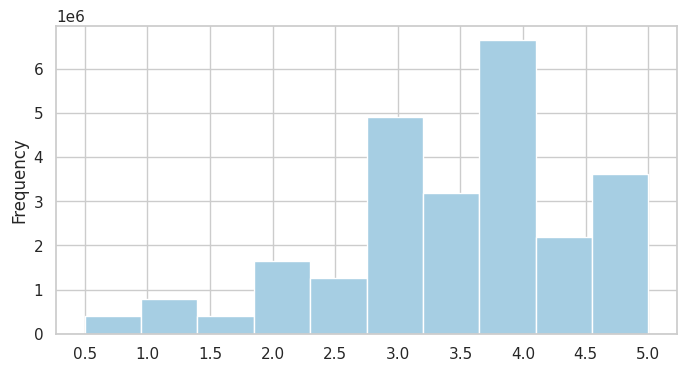

In [14]:
# гистограмма рейтингов
rating["rating"].plot(kind='hist', figsize=(8,4), colormap="Paired", xticks=np.arange(0.5,5.5,0.5));

### Таблица ```movies.csv```
##### **Описание**
Таблица содержит информацию о фильмах. Каждая строка представляет информацию об одном фильме. Названия фильмов вводились вручную или были импортированы с сайта <https://www.themoviedb.org/>.


##### **Формат данных**

```
movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
...
```
##### **Описание полей**

 - ``` movieId``` — идентификатор фильма;
 - ``` title``` — название фильма и год выпуска в скобках после названия;
 - ``` genres``` — список жанров фильма, все жанры записываются в одном поле через разделитель `|`.


Допустимые жанры | $ $
--- | ---
1. Action | 11. Horror
2. Adventure | 12. Musical
3. Animation | 13. Mystery
4. Children's | 14. Romance
5. Comedy | 15. Sci-Fi
6. Crime | 16. Thriller
7. Documentary | 17. War
8. Drama | 18. Western
9. Fantasy | 19. (no genres listed)
10. Film-Noir |  











### Таблица ```genome-tags.csv```
##### **Описание**

[genome-paper]: http://files.grouplens.org/papers/tag_genome.pdf

Tag genome – это структура данных, которая описывает релевантность тегов по отношению к фильму. Заданы 1128 тэгов, и по каждому фильму указаны значения релевантности для каждого тега.

Описание [в статье][genome-paper]. Tag genome был рассчитан с помощью алгоритма на основе пользовательского контента, включая теги, рейтинги и текстовые описания.

Таблица содержит описания тегов.


##### **Формат данных**

```
tagId,tag
2,007 (series)
4,1920s
11,3d
22,adapted from:book
...
```
##### **Описание полей**

 - ``` tagId``` — идентификатор тега, значения сгенерированы в тот момент, когда экспортировался весь набор данных, так что могут быть не такими, как в других версиях датасетов от MovieLens (например, 1М и 20M).;
 - ``` tag``` — название тега.


### Таблица ```genome-scores.csv```
##### **Описание**
Таблица содержит релевантность тегов по отношению к фильмам.

##### **Формат данных**

```
movieId,tagId,relevance
1,3,0.0625
1,5,0.14075
1,8,0.20375
...
```
##### **Описание полей**

 - ``` movieId``` — идентификатор фильма;
 - ``` tagId``` — идентификатор тега;
 - ``` relevance``` — релевантность тега фильму.


In [15]:
# загрузка данных о фильмах и tag genome
movies = pd.read_csv("movies.csv")
genome_scores = pd.read_csv('genome-scores.csv')
genome_tag = pd.read_csv('genome-tags.csv')

In [16]:
# релевантность каждого тега фильму Demolition Man (1993)
genome_scores[genome_scores.movieId == 442]

,movieId,tagId,relevance
474888,442,1,0.04525
474889,442,2,0.04575
474890,442,3,0.03475
474891,442,4,0.04700
474892,442,5,0.06375
...,...,...,...
476011,442,1124,0.04400
476012,442,1125,0.03250
476013,442,1126,0.00800
476014,442,1127,0.11775


In [17]:
# выведем 5 фильмов с самой высокой релевантностью тега "dragon"
genome_tag[genome_tag.tag == 'dragon']

,tagId,tag
320,321,dragon


In [18]:
top5_dragon_genom = genome_scores.query("tagId == 321").nlargest(5, "relevance")
movies[movies.movieId.isin(top5_dragon_genom.movieId)]

,movieId,title,genres
642,653,Dragonheart (1996),Action|Adventure|Fantasy
4933,5039,Dragonslayer (1981),Action|Adventure|Fantasy
14477,76093,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX
20603,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX
21757,112175,How to Train Your Dragon 2 (2014),Action|Adventure|Animation


### Таблица ```links.csv```
##### **Описание**
Таблица содержит идентификаторы фильмов с других ресурсов. В каждой строке находятся ссылки на один фильм.

##### **Формат данных**

```
movieId,imdbId,tmdbId
1,114709,862
2,113497,8844
3,113228,15602
...
```
##### **Описание полей**

 - ``` movieId``` — идентификатор фильма на <https://movielens.org>. Например, фильм "Toy Story" имеет ссылку <https://movielens.org/movies/1>;
 - ``` imdbId``` — идентификатор фильма на <http://www.imdb.com>. Например, фильм Toy Story имеет ссылку <http://www.imdb.com/title/tt0114709/>;
 - ``` tmdbId``` — идентификатор фильма на <https://www.themoviedb.org>. Например, фильм Toy Story имеет ссылку <https://www.themoviedb.org/movie/862>.


# Понимание данных

В таблице `movies.csv` представление жанров не очень хорошее: не очень понятно, что с ними можно делать. Очень часто для подобных данных используется следующий подход: под каждый жанр создается новый столбец, в соответствующем жанру столбце у фильма записывается 1, если в перечне был такой жанр, и 0 – если не было. Этот подход чем-то похож на one-hot encoding.

Вторая проблема с данными – наличие в столбце `title` года выпуска фильма. Лучше всего под год выпуска выделить отдельный столбец.

In [19]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
# объединим таблицы с описаниями фильмов и их рейтингами в одну
data = pd.merge(movies,rating)

# первые 5 строк объединенной таблицы
display(data.head())

# 5 случайных строк из объединенной таблица
data.sample(5)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517


,movieId,title,genres,userId,rating,timestamp
5147596,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery,146588,3.0,850303414
1480407,223,Clerks (1994),Comedy,151723,2.0,837277177
17481865,6405,Treasure Island (1950),Adventure|Children,30998,4.0,1200321975
1026971,150,Apollo 13 (1995),Adventure|Drama|IMAX,40207,4.0,836483833
9486932,1961,Rain Man (1988),Drama,94409,4.0,1172102247


In [21]:
# в таблице number_rating будет храниться общее количество оценок фильму
number_rating = data.groupby('title')['rating'].count().rename("rated_by_users").reset_index()
number_rating.head()

,title,rated_by_users
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",1
1,"""Great Performances"" Cats (1998)",179
2,#1 Cheerleader Camp (2010),9
3,#Captured (2017),2
4,#Female Pleasure (2018),3


In [22]:
# т.к. обработка всей таблицы с рейтингами фильмов от пользователей
# перегружает оперативную память, для примера возьмем случайные 10К строк из нее

data_train = data.sample(10000)
data_train.head()

,movieId,title,genres,userId,rating,timestamp
19377928,31410,"Downfall (Untergang, Der) (2004)",Drama|War,77664,4.0,1429134685
4071490,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,115141,5.0,1483918617
8694655,1653,Gattaca (1997),Drama|Sci-Fi|Thriller,148109,4.0,1119806935
21920225,71156,"Men Who Stare at Goats, The (2009)",Action|Comedy|Drama,121579,4.0,1471929758
5712687,1079,"Fish Called Wanda, A (1988)",Comedy|Crime,134769,3.0,947961009


In [23]:
# составим сводную таблицу рейтингов, который каждый пользователь ставил каждому фильму
movie_pivot = data_train.pivot_table(index=["userId"],
                                     columns=["title"],
                                     values="rating")
movie_pivot.head().T

userId,12,31,67,86,94
title,,,,,
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN
(500) Days of Summer (2009),NaN,NaN,NaN,NaN,NaN
*batteries not included (1987),NaN,NaN,NaN,NaN,NaN
10 Cloverfield Lane (2016),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
[REC] (2007),NaN,NaN,NaN,NaN,NaN
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN


Матрица предпочтений состоит практически из одних нулей.

В такой матрице маловероятно найти хоть что-то. Например, поищем похожий фильм.

In [24]:
watched_movie = movie_pivot['10 Things I Hate About You (1999)']

similar_movies = movie_pivot.corrwith(watched_movie)
similar_movies = similar_movies.sort_values(ascending=False)
similar_movies.head()

,0
title,
10 Things I Hate About You (1999),1.0
'Round Midnight (1986),NaN
"'burbs, The (1989)",NaN
(500) Days of Summer (2009),NaN
*batteries not included (1987),NaN


Судя по результату, фильм похож только сам на себя.

# Практические задания

## Задание 1

Выход из этой ситуации с неудачным поиском похожих фильмов такой.

Будем делать рекомендации не всем и сразу, а конкретному пользователю. Формировать `movie_pivot` будем только для этого конкретного пользователя.

1. Возьмём все оценки, которые поставил пользователь $U$
2. По фильмам $M_U$, которые он оценил, получим всех пользователей, которые ставили этим фильмам оценки
3. Скорее всего, на этом этапе список получится большим (для случайного пользователя может получиться около 2 миллионов строк). Например, оставить только пользователей, у которых много общих фильмов.
4. Для каждого пользователя посчитаем похожесть (например, корреляцию).
5. Отсортируем пользователей по похожести.
6. Оставим только $k$ самых похожих пользователей.

### Пример решения

Выбираем случайного пользователя.

In [25]:
all_users = rating['userId'].value_counts()
user = all_users.sample(1).index
user

Index([69161], dtype='int64', name='userId')

Получаем фильмы, которые пользователь посмотрел.

In [26]:
user_movies = data[data.userId == user[0]]
user_movies = user_movies.drop(['genres', 'timestamp', 'userId'], axis = 1)
user_movies.head()

,movieId,title,rating
161351,10,GoldenEye (1995),4.5
261075,19,Ace Ventura: When Nature Calls (1995),3.5
506453,44,Mortal Kombat (1995),3.5
1204040,165,Die Hard: With a Vengeance (1995),3.5
1708215,260,Star Wars: Episode IV - A New Hope (1977),4.0


Теперь найдем пользователей, которые смотрели эти фильмы.

In [27]:
new_data = data[data.movieId.isin(user_movies.movieId)]
new_data = new_data.drop(['genres', 'timestamp'], axis = 1)
new_data.sample(10)

,movieId,title,userId,rating
13149904,3175,Galaxy Quest (1999),24411,4.0
2156351,318,"Shawshank Redemption, The (1994)",46301,5.0
18176400,7153,"Lord of the Rings: The Return of the King, The...",160183,4.0
22922793,91529,"Dark Knight Rises, The (2012)",62422,4.5
7208868,1265,Groundhog Day (1993),135726,4.0
6569305,1210,Star Wars: Episode VI - Return of the Jedi (1983),153677,1.0
23271194,99112,Jack Reacher (2012),53327,3.5
1687924,260,Star Wars: Episode IV - A New Hope (1977),21007,3.0
9260071,1909,"X-Files: Fight the Future, The (1998)",38752,3.5
2177207,318,"Shawshank Redemption, The (1994)",88066,5.0


Как по `ID` пользователя получить список его фильмов:

In [28]:
users_group = new_data.groupby(['userId'])
users_group.get_group(user[0]).head()

,movieId,title,userId,rating
161351,10,GoldenEye (1995),69161,4.5
261075,19,Ace Ventura: When Nature Calls (1995),69161,3.5
506453,44,Mortal Kombat (1995),69161,3.5
1204040,165,Die Hard: With a Vengeance (1995),69161,3.5
1708215,260,Star Wars: Episode IV - A New Hope (1977),69161,4.0


In [29]:
user[0]

np.int64(69161)

In [30]:
# выведем фильмы трех пользователей, оценивших больше всего фильмов в выборке
sorted_users_group = sorted(users_group,  key=lambda x: len(x[1]), reverse=True)
for user_movies_group in sorted_users_group[:3]:
  display(user_movies_group[1])

,movieId,title,userId,rating
161351,10,GoldenEye (1995),69161,4.5
261075,19,Ace Ventura: When Nature Calls (1995),69161,3.5
506453,44,Mortal Kombat (1995),69161,3.5
1204040,165,Die Hard: With a Vengeance (1995),69161,3.5
1708215,260,Star Wars: Episode IV - A New Hope (1977),69161,4.0
...,...,...,...,...
24360592,138036,The Man from U.N.C.L.E. (2015),69161,5.0
24504311,152077,10 Cloverfield Lane (2016),69161,4.0
24582494,160563,The Legend of Tarzan (2016),69161,3.5
24648872,165101,Inferno (2016),69161,4.0


,movieId,title,userId,rating
159348,10,GoldenEye (1995),57548,1.0
259571,19,Ace Ventura: When Nature Calls (1995),57548,1.5
505661,44,Mortal Kombat (1995),57548,0.5
1201700,165,Die Hard: With a Vengeance (1995),57548,2.5
1703269,260,Star Wars: Episode IV - A New Hope (1977),57548,2.5
...,...,...,...,...
24360365,138036,The Man from U.N.C.L.E. (2015),57548,0.5
24504038,152077,10 Cloverfield Lane (2016),57548,3.0
24582431,160563,The Legend of Tarzan (2016),57548,0.5
24648822,165101,Inferno (2016),57548,0.5


,movieId,title,userId,rating
161898,10,GoldenEye (1995),72315,3.0
261490,19,Ace Ventura: When Nature Calls (1995),72315,1.5
506652,44,Mortal Kombat (1995),72315,2.5
1204675,165,Die Hard: With a Vengeance (1995),72315,3.0
1709524,260,Star Wars: Episode IV - A New Hope (1977),72315,4.0
...,...,...,...,...
24360668,138036,The Man from U.N.C.L.E. (2015),72315,3.0
24504380,152077,10 Cloverfield Lane (2016),72315,3.5
24582506,160563,The Legend of Tarzan (2016),72315,3.0
24648890,165101,Inferno (2016),72315,2.5


Выведем `ID` пользователя, у которого больше всего похожих фильмов.

In [31]:
similar_movies_user = sorted_users_group[1][0] # скорее всего, в sorted_users_group[0][0] сидит сам пользователь

In [32]:
person2 = users_group.get_group(similar_movies_user).sort_values(by='movieId')

Получим список одинаковых фильмов для двух пользователей с оценками.

In [33]:
temp = user_movies[user_movies['movieId'].isin(users_group.get_group(similar_movies_user)['movieId'])]
person1 = temp.sort_values(by='movieId')

Посчитаем коэффициент корреляции Пирсона для этих двух пользователей


In [34]:
from scipy.stats import pearsonr
pearsonr(person1.rating, person2.rating)[0]

np.float64(0.21032517578106547)

**Дальше нужно дописать самостоятельно.** Нужно пройтись по всем пользователям и отсортировать их по похожести и оставить $k$ самых похожих.

> Далее в коде приведены примеры расчетов для случайных пользователей. Их нужно заменить своими.

In [36]:
users = list(users_group.groups.keys())
# Убираем целевого пользователя из списка
users = [u for u in users if u != user[0]]
# Ограничиваем количество пользователей для скорости вычислений
users = users[:100]  # можно увеличить до 500 или 1000 при необходимости

pearsonCorDict = {}

for u in users:
    try:
        # Получаем фильмы пользователя u
        person2 = users_group.get_group(u).sort_values(by='movieId')

        # Находим общие фильмы между целевым пользователем и пользователем u
        common_movies = user_movies[user_movies['movieId'].isin(person2['movieId'])]

        # Если общих фильмов меньше 3, пропускаем (слишком мало данных для корреляции)
        if len(common_movies) < 3:
            continue

        # Сортируем общие фильмы по movieId для корректного сопоставления
        person1_common = common_movies.sort_values(by='movieId')
        person2_common = person2[person2['movieId'].isin(common_movies['movieId'])].sort_values(by='movieId')

        # Убеждаемся, что порядок фильмов одинаковый
        if len(person1_common) == len(person2_common):
            # Вычисляем корреляцию Пирсона
            correlation, _ = pearsonr(person1_common['rating'].values, person2_common['rating'].values)

            # Сохраняем только значимые корреляции (не NaN и не слишком низкие)
            if not np.isnan(correlation) and abs(correlation) > 0.1:
                pearsonCorDict[u] = correlation
    except Exception as e:
        # Пропускаем пользователей, для которых возникают ошибки
        continue


In [37]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,0.301095,2
1,0.136027,3
2,0.327561,4
3,-0.500000,7
4,-0.246870,9


In [38]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[:7]
topUsers

,similarityIndex,userId
54,1.000000,77
18,0.866025,24
30,0.852803,39
32,0.771975,41
48,0.643254,70
14,0.588655,20
19,0.581318,25


Теперь у нас есть похожие пользователи. Получим оценки, которые они ставили за все фильмы.

In [39]:
topUsersRating=topUsers.merge(data, left_on='userId', right_on='userId', how='inner')
topUsersRating.sample(10)

,similarityIndex,userId,movieId,title,genres,rating,timestamp
249,0.771975,41,2527,Westworld (1973),Action|Sci-Fi|Thriller|Western,3.0,944572268
622,0.581318,25,318,"Shawshank Redemption, The (1994)",Crime|Drama,5.0,836216950
279,0.771975,41,2944,"Dirty Dozen, The (1967)",Action|Drama|War,5.0,944572531
580,0.581318,25,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,2.0,836217326
446,0.643254,70,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,3.5,1255209111
631,0.581318,25,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,4.0,836217082
602,0.581318,25,235,Ed Wood (1994),Comedy|Drama,4.0,836217158
222,0.771975,41,2273,Rush Hour (1998),Action|Comedy|Crime|Thriller,4.0,944572627
652,0.581318,25,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,4.0,836216929
470,0.643254,70,30812,"Aviator, The (2004)",Drama,3.5,1255204913


Уберем лишние столбцы и получим взвешенную оценку за фильм.

In [40]:
topUsersRating = topUsersRating.drop(['genres', 'timestamp'], axis = 1)
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,title,rating,weightedRating
0,1.0,77,1,Toy Story (1995),4.0,4.0
1,1.0,77,5,Father of the Bride Part II (1995),3.0,3.0
2,1.0,77,19,Ace Ventura: When Nature Calls (1995),3.0,3.0
3,1.0,77,60,"Indian in the Cupboard, The (1995)",3.0,3.0
4,1.0,77,62,Mr. Holland's Opus (1995),3.0,3.0


Теперь нужно сгруппировать по фильмам и получить сумму взвешенных оценок.

In [43]:
tempTopUsersRating = topUsersRating.groupby(['movieId', 'title']).agg({
    'rating': 'mean',  # средний рейтинг фильма
    'similarityIndex': 'sum'  # сумма коэффициентов схожести пользователей, которые оценили этот фильм
}).reset_index()

# Вычисляем взвешенную оценку для каждого фильма
tempTopUsersRating['weighted_rating'] = tempTopUsersRating['rating'] * tempTopUsersRating['similarityIndex']

# Сортируем по взвешенной оценке в порядке убывания
tempTopUsersRating = tempTopUsersRating.sort_values('weighted_rating', ascending=False)

tempTopUsersRating.head()

,movieId,title,rating,similarityIndex,weighted_rating
77,318,"Shawshank Redemption, The (1994)",4.400,3.532056,15.541045
59,260,Star Wars: Episode IV - A New Hope (1977),3.900,3.438006,13.408222
120,527,Schindler's List (1993),4.375,2.943401,12.877380
147,858,"Godfather, The (1972)",4.375,2.869910,12.555855
108,457,"Fugitive, The (1993)",4.125,2.996548,12.360761


Теперь можно получить рекомендацию.

In [45]:
recommendation_df = pd.DataFrame()

# Используем правильные названия колонок из tempTopUsersRating
recommendation_df['score'] = tempTopUsersRating['weighted_rating'] / tempTopUsersRating['similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating['movieId']
recommendation_df['title'] = tempTopUsersRating['title']
recommendation_df = recommendation_df.sort_values(by='score', ascending=False)
recommendation_df

,score,movieId,title
63,5.0,280,Murder in the First (1995)
32,5.0,151,Rob Roy (1995)
14,5.0,36,Dead Man Walking (1995)
17,5.0,47,Seven (a.k.a. Se7en) (1995)
70,5.0,300,Quiz Show (1994)
...,...,...,...
487,0.5,63393,Camp Rock (2008)
492,0.5,71537,Fame (2009)
406,0.5,4124,Jaws: The Revenge (1987)
214,0.5,1389,Jaws 3-D (1983)


In [46]:
# найдем количество рекомендаций с рейтингом выше 4.5
recommendation_df = recommendation_df[recommendation_df.score > 4.5]
recommendation_df = recommendation_df.drop(['movieId'], axis = 1)
recommendation_df.shape

(36, 2)

In [48]:
if 'movieId' in recommendation_df.columns:
    recommended_movies = recommendation_df.merge(movies, how='inner', on='movieId')
else:
    # Если нет, попробуем другие варианты
    print("\nКолонка 'movieId' не найдена в recommendation_df")
    print("Попытка найти альтернативные колонки для объединения...")

    # Проверим, есть ли другие колонки для объединения
    common_columns = set(recommendation_df.columns) & set(movies.columns)
    print(f"Общие колонки: {common_columns}")

    if 'title' in common_columns:
        recommended_movies = recommendation_df.merge(movies, how='inner', on='title')
    else:
        # Если ничего не найдено, создаем колонку movieId
        print("Создаем колонку movieId из индекса...")
        recommendation_df = recommendation_df.reset_index()
        if 'movieId' in recommendation_df.columns:
            recommended_movies = recommendation_df.merge(movies, how='inner', on='movieId')
        else:
            print("Не удалось найти подходящую колонку для объединения")

recommended_movies.head()


Колонка 'movieId' не найдена в recommendation_df
Попытка найти альтернативные колонки для объединения...
Общие колонки: {'title'}


,score,title,movieId,genres
0,5.0,Murder in the First (1995),280,Drama|Thriller
1,5.0,Rob Roy (1995),151,Action|Drama|Romance|War
2,5.0,Dead Man Walking (1995),36,Crime|Drama
3,5.0,Seven (a.k.a. Se7en) (1995),47,Mystery|Thriller
4,5.0,Quiz Show (1994),300,Drama


Результат есть. Но теперь нужно оценить качество этой рекомендации.

**Задача следующая:** разделить исходные данные на `train` и `test`. Получить предсказания на `train` и проверить их на `test`.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Задание 1.5: Разделение на train/test и оценка качества

# 1. Разделяем данные на обучающую и тестовую выборки
def split_ratings_data(rating, test_size=0.2, random_state=42):
    """
    Разделяет данные о рейтингах на train и test
    """
    # Сортируем по времени для временного разделения (более реалистично)
    rating_sorted = rating.sort_values('timestamp')

    # Разделяем данные
    train_data, test_data = train_test_split(
        rating_sorted,
        test_size=test_size,
        random_state=random_state,
        stratify=rating_sorted['userId']  # стратификация по пользователям
    )

    return train_data, test_data

# Разделяем данные
train_data, test_data = split_ratings_data(rating)
print(f"Размер train: {len(train_data)}")
print(f"Размер test: {len(test_data)}")

# 2. Функция для получения предсказаний на основе нашей системы рекомендаций
def predict_ratings(user_id, movie_ids, train_data, n_similar_users=10):
    """
    Предсказывает рейтинги для заданных фильмов для конкретного пользователя
    """
    predictions = {}

    # Получаем данные пользователя из train
    user_movies_train = train_data[train_data['userId'] == user_id]

    if len(user_movies_train) == 0:
        # Если пользователя нет в train, возвращаем средний рейтинг по всем фильмам
        avg_rating = train_data['rating'].mean()
        return {movie_id: avg_rating for movie_id in movie_ids}

    # Находим похожих пользователей (упрощенная версия нашего алгоритма)
    similar_users = find_similar_users(user_id, train_data, n_similar_users)

    for movie_id in movie_ids:
        # Если пользователь уже оценил этот фильм в train, используем его оценку
        user_rating = user_movies_train[user_movies_train['movieId'] == movie_id]['rating']
        if len(user_rating) > 0:
            predictions[movie_id] = user_rating.iloc[0]
            continue

        # Иначе предсказываем на основе похожих пользователей
        movie_ratings = []
        weights = []

        for similar_user_id, similarity in similar_users.items():
            similar_user_rating = train_data[
                (train_data['userId'] == similar_user_id) &
                (train_data['movieId'] == movie_id)
            ]['rating']

            if len(similar_user_rating) > 0:
                movie_ratings.append(similar_user_rating.iloc[0])
                weights.append(similarity)

        if movie_ratings:
            # Взвешенное среднее на основе схожести
            weighted_avg = np.average(movie_ratings, weights=weights)
            predictions[movie_id] = weighted_avg
        else:
            # Если никто из похожих пользователей не оценил фильм
            predictions[movie_id] = train_data['rating'].mean()

    return predictions

# 3. Упрощенная функция для поиска похожих пользователей
def find_similar_users(target_user_id, train_data, n_similar_users=10):
    """
    Упрощенная версия поиска похожих пользователей для оценки качества
    """
    similar_users = {}

    # Получаем фильмы целевого пользователя
    target_user_movies = train_data[train_data['userId'] == target_user_id]

    if len(target_user_movies) == 0:
        return similar_users

    # Находим пользователей с общими фильмами
    common_users_data = train_data[
        train_data['movieId'].isin(target_user_movies['movieId']) &
        (train_data['userId'] != target_user_id)
    ]

    users_with_common_movies = common_users_data['userId'].unique()

    for user_id in users_with_common_movies[:100]:  # ограничиваем для скорости
        user_movies = train_data[train_data['userId'] == user_id]

        # Находим общие фильмы
        common_movies = pd.merge(
            target_user_movies,
            user_movies,
            on='movieId',
            suffixes=('_target', '_other')
        )

        if len(common_movies) >= 3:
            try:
                corr, _ = pearsonr(
                    common_movies['rating_target'],
                    common_movies['rating_other']
                )
                if not np.isnan(corr) and abs(corr) > 0.1:
                    similar_users[user_id] = corr
            except:
                continue

    # Возвращаем топ-N похожих пользователей
    return dict(sorted(similar_users.items(), key=lambda x: x[1], reverse=True)[:n_similar_users])

# 4. Оценка качества на тестовой выборке
def evaluate_recommendation_system(train_data, test_data, n_test_users=50):
    """
    Оценивает качество системы рекомендаций на тестовой выборке
    """
    # Выбираем случайных пользователей из test для оценки
    test_users = test_data['userId'].unique()[:n_test_users]

    all_predictions = []
    all_actual = []

    for user_id in test_users:
        # Получаем фильмы, которые пользователь оценил в test
        user_test_movies = test_data[test_data['userId'] == user_id]

        if len(user_test_movies) == 0:
            continue

        movie_ids = user_test_movies['movieId'].tolist()
        actual_ratings = user_test_movies['rating'].tolist()

        # Получаем предсказания
        predictions_dict = predict_ratings(user_id, movie_ids, train_data)

        # Собираем предсказания и фактические значения
        for movie_id, actual_rating in zip(movie_ids, actual_ratings):
            if movie_id in predictions_dict:
                all_predictions.append(predictions_dict[movie_id])
                all_actual.append(actual_rating)

    # Вычисляем метрики качества
    if all_predictions:
        mse = mean_squared_error(all_actual, all_predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_actual, all_predictions)

        print(f"Оценка качества на {len(all_predictions)} тестовых примерах:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")

        # Дополнительная метрика - точность предсказаний
        correct_predictions = sum(1 for pred, actual in zip(all_predictions, all_actual)
                                if abs(pred - actual) <= 0.5)
        accuracy = correct_predictions / len(all_predictions)
        print(f"Accuracy (±0.5): {accuracy:.4f}")

        return rmse, mae, accuracy
    else:
        print("Не удалось получить предсказания для оценки")
        return None, None, None

# 5. Запускаем оценку
print("Запуск оценки качества системы рекомендаций...")
rmse, mae, accuracy = evaluate_recommendation_system(train_data, test_data, n_test_users=100)

# 6. Сравнение с базовыми методами
def baseline_predictions(train_data, test_data, n_test_users=50):
    """
    Базовые методы для сравнения
    """
    test_users = test_data['userId'].unique()[:n_test_users]

    # Метод 1: Средний рейтинг по всем фильмам
    global_mean = train_data['rating'].mean()

    # Метод 2: Средний рейтинг пользователя
    user_means = train_data.groupby('userId')['rating'].mean()

    # Метод 3: Средний рейтинг фильма
    movie_means = train_data.groupby('movieId')['rating'].mean()

    baseline_results = {}

    for user_id in test_users:
        user_test_movies = test_data[test_data['userId'] == user_id]

        if len(user_test_movies) == 0:
            continue

        movie_ids = user_test_movies['movieId'].tolist()
        actual_ratings = user_test_movies['rating'].tolist()

        # Предсказания разными методами
        global_pred = [global_mean] * len(movie_ids)

        user_mean = user_means.get(user_id, global_mean)
        user_pred = [user_mean] * len(movie_ids)

        movie_pred = [movie_means.get(movie_id, global_mean) for movie_id in movie_ids]

        baseline_results[user_id] = {
            'actual': actual_ratings,
            'global_mean': global_pred,
            'user_mean': user_pred,
            'movie_mean': movie_pred
        }

    return baseline_results

# Оценка базовых методов
print("\nСравнение с базовыми методами:")
baseline_results = baseline_predictions(train_data, test_data, n_test_users=100)

# Вычисляем метрики для базовых методов
methods = ['global_mean', 'user_mean', 'movie_mean']
for method in methods:
    all_actual = []
    all_pred = []

    for user_data in baseline_results.values():
        all_actual.extend(user_data['actual'])
        all_pred.extend(user_data[method])

    rmse_baseline = np.sqrt(mean_squared_error(all_actual, all_pred))
    mae_baseline = mean_absolute_error(all_actual, all_pred)

    print(f"{method}: RMSE = {rmse_baseline:.4f}, MAE = {mae_baseline:.4f}")

Размер train: 20000076
Размер test: 5000019
Запуск оценки качества системы рекомендаций...


## Задание 2

Проведите EDA (exploratory data analysis, разведочный анализ данных):
1. Посмотрите как менялась популярность тегов со временем.
2. Сделайте и оцените кластеризацию тегов и кластеризацию фильмов.
3. Посчитайте и визуализируйте статистики по тегам, жанрам, годам.
4. Изучите "тег геном" для поиска похожих фильмов.

In [ ]:
# 1. Загрузка данных
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# 2. Объединение таблиц для удобства
# Сгруппируем рейтинги по movieId, посчитаем количество оценок (count) и среднюю (mean)
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])

# Присоединим названия фильмов и жанры
df = movies.merge(movie_stats, on='movieId', how='left')

# Заменим NaN на 0 (для фильмов без оценок)
df['count'] = df['count'].fillna(0)
df['mean'] = df['mean'].fillna(0)

print("Топ-5 фильмов по количеству оценок:")
display(df.sort_values(by='count', ascending=False).head())

# 3. Визуализация распределения оценок
plt.figure(figsize=(10,6))
sns.histplot(df[df['count'] > 50]['mean'], bins=50, kde=True, color='teal')
plt.title('Распределение средних оценок (для фильмов с > 50 голосами)')
plt.xlabel('Средняя оценка')
plt.ylabel('Количество фильмов')
plt.show()

# 4. Визуализация "Длинного хвоста" (Long Tail)
# Большинство фильмов имеют мало оценок, а популярные - очень много.
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='mean', y='count', alpha=0.3)
plt.title('Зависимость между средней оценкой и количеством голосов')
plt.xlabel('Средняя оценка')
plt.ylabel('Количество голосов')
plt.show()

## Задание 3

Сделайте рекомендацию фильмов на основе контента:
1. Будем считать, что описание фильма состоит из его тегов.
2. Когда пользователь ставит оценку за фильм, ее нужно засчитать как оценку за теги.
3. Рекомендацией будем считать фильмы с тегами, которые пользователь оценил выше всего.



In [ ]:
# --- ПОДГОТОВКА ДАННЫХ (Сэмплирование) ---

# Оставим только популярные фильмы (более 1000 оценок), чтобы уменьшить размерность
popular_movies_ids = df[df['count'] > 1000]['movieId'].values
ratings_filtered = ratings[ratings['movieId'].isin(popular_movies_ids)]

# Ограничим количество пользователей (например, первые 5000 уникальных пользователей из отфильтрованного списка)
# Это нужно, чтобы Colab не вылетел из-за нехватки памяти
unique_users = ratings_filtered['userId'].unique()[:5000]
ratings_sample = ratings_filtered[ratings_filtered['userId'].isin(unique_users)]

print(f"Размер выборки: {ratings_sample.shape[0]} оценок")

# --- СОЗДАНИЕ МАТРИЦЫ ПРЕДПОЧТЕНИЙ ---
# Индекс - пользователь, Столбец - фильм, Значение - оценка
user_movie_matrix = ratings_sample.pivot_table(index='userId', columns='movieId', values='rating')

# Заполняем пропуски нулями (или можно средним, но для корреляции нули допустимы при разреженной матрице)
# Однако для корреляции Пирсона лучше оставить NaN, но pandas corr() умеет с ними работать,
# или использовать Centered Cosine Similarity. Для простоты здесь используем трансиозирование и corr.

print("Размерность матрицы (Users x Movies):", user_movie_matrix.shape)
display(user_movie_matrix.iloc[:5, :5]) # Показать кусочек матрицы

# --- ПОИСК ПОХОЖИХ ПОЛЬЗОВАТЕЛЕЙ ---

# Функция для поиска похожих пользователей и рекомендации
def get_recommendations(target_user_id, matrix, n_recommendations=5):
    if target_user_id not in matrix.index:
        return "Пользователь не найден в выборке."

    # Транспонируем, чтобы corr() считала корреляцию между строками (пользователями)
    # Внимание: Это ресурсоемкая операция. В реальных задачах используют NearestNeighbors из sklearn.
    # Здесь используем упрощенный подход: корреляция целевого юзера со всеми остальными.

    user_ratings = matrix.loc[target_user_id]
    similar_scores = matrix.corrwith(user_ratings, axis=1, method='pearson')

    # Сортируем пользователей по схожести (от самого похожего)
    similar_users = similar_scores.sort_values(ascending=False)

    # Убираем самого себя из топа (корреляция = 1.0)
    similar_users = similar_users.drop(target_user_id)

    # Берем топ-10 похожих пользователей
    top_similar_users = similar_users.head(10)

    # Собираем фильмы, которые смотрели эти похожие люди, но НЕ смотрел наш пользователь
    suggested_movies = []

    # Фильмы, которые уже видел целевой пользователь (чтобы не рекомендовать их снова)
    watched_movies = user_ratings[user_ratings.notna()].index

    for user in top_similar_users.index:
        # Оценки похожего пользователя
        sim_user_ratings = matrix.loc[user]
        # Фильмы с высокой оценкой (>= 4)
        top_movies = sim_user_ratings[sim_user_ratings >= 4].index

        for movie in top_movies:
            if movie not in watched_movies:
                suggested_movies.append(movie)

    # Считаем частоту встречаемости рекомендованных фильмов среди похожих юзеров
    from collections import Counter
    movie_counts = Counter(suggested_movies)

    # Топ N фильмов
    top_recs = movie_counts.most_common(n_recommendations)

    rec_ids = [m[0] for m in top_recs]

    # Возвращаем названия
    return movies[movies['movieId'].isin(rec_ids)][['title', 'genres']]

# --- ТЕСТИРОВАНИЕ ---
# Выберем случайного пользователя из нашей выборки
test_user = unique_users[10]
print(f"Рекомендации для пользователя ID {test_user}:")
recs = get_recommendations(test_user, user_movie_matrix)
display(recs)

# Порядок защиты работы

**Для защиты работы необходимо:**
1. Предоставить результаты выполнения 3 заданий в виде ссылки на Google Colab.
2. Выполнить дополнительное задание в процессе сдачи работы. Дополнительное задание представляет собой обработку данных лабораторной работы, по сложности аналогичную той, что требовалось выполнить в рамках работы.

**Примеры дополнительных заданий:**

1. Сделайте неперсонализированную рекомендацию фильма по имеющимся данным. Можно, например, найти фильм с самой высокой средней оценкой по каждому жанру или за какой-то период.
2. В текущем задании был реализован `user-based` подход. Перепишите код так, чтобы был реализован `item-based` подход.

In [ ]:
# Выполнение дополнительного задания №2

# --- ДОП. ЗАДАНИЕ 2: ITEM-BASED COLLABORATIVE FILTERING ---

# Используем ту же матрицу user_movie_matrix из Задания 3.
# Напоминание: user_movie_matrix - это pivot_table (строки=userId, столбцы=movieId).

def get_item_based_recommendations(movie_title, matrix, n_recommendations=5):
    # 1. Находим ID фильма по названию
    # (Ищем точное совпадение или первое частичное)
    try:
        # Пытаемся найти точное совпадение
        target_movie_id = movies[movies['title'] == movie_title]['movieId'].values[0]
    except IndexError:
        return f"Фильм '{movie_title}' не найден в базе данных movies."

    # 2. Проверяем, есть ли этот фильм в нашей матрице (попал ли он в выборку популярных)
    if target_movie_id not in matrix.columns:
        return "Этот фильм недостаточно популярен (нет в матрице выборки)."

    # 3. Получаем вектор оценок для выбранного фильма
    # Это колонка в нашей матрице: как все пользователи оценили этот конкретный фильм
    movie_ratings = matrix[target_movie_id]

    # 4. Считаем корреляцию этого фильма со ВСЕМИ остальными фильмами (столбцами)
    # В User-Based мы использовали axis=1 (строки), здесь используем axis=0 (столбцы, по умолчанию)
    # Это самая тяжелая операция.
    similar_scores = matrix.corrwith(movie_ratings)

    # 5. Очистка и сортировка результатов
    # Удаляем NaN (где не было пересечений пользователей)
    similar_scores = similar_scores.dropna()

    # Сортируем от 1.0 (полное совпадение) вниз
    similar_movies = similar_scores.sort_values(ascending=False)

    # Убираем сам фильм из рекомендаций (он всегда будет первым с корреляцией 1.0)
    if target_movie_id in similar_movies.index:
        similar_movies = similar_movies.drop(target_movie_id)

    # Берем топ-N
    top_movie_ids = similar_movies.head(n_recommendations).index

    # 6. Формируем красивый ответ с названиями
    result_df = movies[movies['movieId'].isin(top_movie_ids)].copy()

    # Добавляем колонку с коэффициентом схожести (корреляцией)
    result_df['similarity'] = result_df['movieId'].map(similar_movies)

    # Сортируем результат, чтобы порядок соответствовал корреляции
    result_df = result_df.sort_values(by='similarity', ascending=False)

    return result_df[['title', 'genres', 'similarity']]

# --- ТЕСТИРОВАНИЕ ---

target_movie = 'Star Wars: Episode IV - A New Hope (1977)'
print(f"Фильмы, похожие на '{target_movie}' (Item-Based):")

recs_item_based = get_item_based_recommendations(target_movie, user_movie_matrix)

if isinstance(recs_item_based, str):
    print(recs_item_based)
else:
    display(recs_item_based)

print("-" * 30)

target_movie_2 = 'Pulp Fiction (1994)'
print(f"Фильмы, похожие на '{target_movie_2}' (Item-Based):")
display(get_item_based_recommendations(target_movie_2, user_movie_matrix))

# Дополнительные материалы

1. Рекомендательные системы [Электронный ресурс]. URL: https://neerc.ifmo.ru/wiki/index.php?title=Рекомендательные_системы (дата обращения: 02.04.2024).
2. Surprise: A Python scikit for recommender systems [Электронный ресурс]. URL: https://surpriselib.com/ (дата обращения: 02.04.2024).
